In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

from sklearn.metrics import classification_report, accuracy_score
import random
random.seed(100)

In [2]:
data = pd.read_csv(r'../data/interim/training_data.csv')
data.shape

(558211, 41)

In [3]:
data.head()

,Unnamed: 0,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,ClaimPeriod,TimeInHptal,Diagnosis Count,Procedures Count,SamePhysician,OPD_Flag,PotentialFraud,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,BirthYear,Age,Alive,ChronicDisease_Count
0,0,BENE11001,CLM46614,PRV55912,26000,1068.0,6,6,9.0,0.0,0.0,0,1,1943-01-01,2009-12-01,Male,White,0,Pennsylvania,230,12,12,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,36000,3204,60,70,1943,67.0,0,7.0
1,1,BENE11001,CLM66048,PRV55907,5000,1068.0,2,2,3.0,1.0,1.0,0,0,1943-01-01,2009-12-01,Male,White,0,Pennsylvania,230,12,12,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,36000,3204,60,70,1943,67.0,0,7.0
2,2,BENE11001,CLM68358,PRV56046,5000,1068.0,3,3,6.0,0.0,0.0,0,0,1943-01-01,2009-12-01,Male,White,0,Pennsylvania,230,12,12,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,36000,3204,60,70,1943,67.0,0,7.0
3,3,BENE11011,CLM38412,PRV52405,5000,1068.0,8,8,9.0,1.0,0.0,0,0,1914-03-01,2009-12-01,Female,Black or African American,0,Alabama,360,12,12,No,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,5000,1068,250,320,1914,96.0,0,6.0
4,4,BENE11014,CLM63689,PRV56614,10000,1068.0,17,17,9.0,1.0,0.0,0,0,1938-04-01,2009-12-01,Female,White,1,Utah,780,12,12,No,Yes,Yes,No,Yes,Yes,No,Yes,No,No,No,21260,2136,120,100,1938,72.0,0,5.0


In [4]:
del data['Unnamed: 0']

In [5]:
# data.isna().sum()

In [6]:
# total 899 values with -1 replacing those with 0
data['DeductibleAmtPaid'] = data['DeductibleAmtPaid'].replace(-1, 0)

In [7]:
data['OPD_Flag'] = data['OPD_Flag'].astype('object')
data['SamePhysician'] = data['SamePhysician'].astype('object')
data['RenalDiseaseIndicator'] = data['RenalDiseaseIndicator'].astype('object')

In [8]:
data = data[data['IPAnnualReimbursementAmt']>=0].reset_index(drop=True)
data = data[data['OPAnnualReimbursementAmt']>=0].reset_index(drop=True)
data.shape

(558138, 40)

In [9]:
# data.tail()

### Columns to be treat (Contains Outliers)

1. InscClaimAmtReimbursed
2. IPAnnualReimbursementAmt
3. OPAnnualReimbursementAmt
4. OPAnnualDeductibleAmt
5. IPAnnualDeductibleAmt


#### Outlier Treatment

In [10]:
def treat_outliers(df, columns):
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Cap outliers
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [11]:
data = treat_outliers(data, ['InscClaimAmtReimbursed', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                            'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt'])

In [12]:
data.describe()

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClaimPeriod,TimeInHptal,Diagnosis Count,Procedures Count,PotentialFraud,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,BirthYear,Age,Alive,ChronicDisease_Count
count,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.0,558138.000000
mean,214.277258,78.275842,1.727711,0.410630,3.010793,0.053537,0.381212,378.587666,11.931463,11.938762,3346.451523,502.191917,1775.557649,533.814659,1935.723183,73.769772,0.0,4.498626
std,248.572190,273.782870,4.904651,2.112183,2.448085,0.280484,0.485685,265.210830,0.889769,0.785951,5434.170231,785.740737,1692.759775,526.272005,13.011398,13.022134,0.0,2.332332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1909.000000,26.000000,0.0,0.000000
25%,40.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,150.000000,12.000000,12.000000,0.000000,0.000000,460.000000,120.000000,1927.000000,68.000000,0.0,3.000000
50%,80.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,350.000000,12.000000,12.000000,0.000000,0.000000,1170.000000,340.000000,1935.000000,75.000000,0.0,5.000000
75%,300.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,570.000000,12.000000,12.000000,6000.000000,1068.000000,2590.000000,790.000000,1941.000000,82.000000,0.0,6.000000
max,690.000000,1068.000000,36.000000,35.000000,10.000000,5.000000,1.000000,999.000000,12.000000,12.000000,15000.000000,2670.000000,5785.000000,1795.000000,1983.000000,101.000000,0.0,11.000000


In [13]:
# plt.hist(data['OPAnnualDeductibleAmt'])

In [14]:
# data[(data['ClaimPeriod']==0) & (data['OPD_Flag']==0) & (data['PotentialFraud']==0)].shape

In [15]:
data.describe()

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClaimPeriod,TimeInHptal,Diagnosis Count,Procedures Count,PotentialFraud,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,BirthYear,Age,Alive,ChronicDisease_Count
count,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.000000,558138.0,558138.000000
mean,214.277258,78.275842,1.727711,0.410630,3.010793,0.053537,0.381212,378.587666,11.931463,11.938762,3346.451523,502.191917,1775.557649,533.814659,1935.723183,73.769772,0.0,4.498626
std,248.572190,273.782870,4.904651,2.112183,2.448085,0.280484,0.485685,265.210830,0.889769,0.785951,5434.170231,785.740737,1692.759775,526.272005,13.011398,13.022134,0.0,2.332332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1909.000000,26.000000,0.0,0.000000
25%,40.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,150.000000,12.000000,12.000000,0.000000,0.000000,460.000000,120.000000,1927.000000,68.000000,0.0,3.000000
50%,80.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,350.000000,12.000000,12.000000,0.000000,0.000000,1170.000000,340.000000,1935.000000,75.000000,0.0,5.000000
75%,300.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,570.000000,12.000000,12.000000,6000.000000,1068.000000,2590.000000,790.000000,1941.000000,82.000000,0.0,6.000000
max,690.000000,1068.000000,36.000000,35.000000,10.000000,5.000000,1.000000,999.000000,12.000000,12.000000,15000.000000,2670.000000,5785.000000,1795.000000,1983.000000,101.000000,0.0,11.000000


In [17]:
# pd.crosstab(data['PotentialFraud'], data['NoOfMonths_PartACov'])

In [21]:
data.drop(columns={'DOB', 'DOD', 'State', 'County', 'Alive'}, inplace=True)

In [22]:
data.columns

Index(['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'DeductibleAmtPaid', 'ClaimPeriod', 'TimeInHptal', 'Diagnosis Count',
       'Procedures Count', 'SamePhysician', 'OPD_Flag', 'PotentialFraud',
       'Gender', 'Race', 'RenalDiseaseIndicator', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'BirthYear', 'Age',
       'ChronicDisease_Count'],
      dtype='object')

### Categorical Columns overview

In [24]:
# data.dtypes

In [25]:
data.select_dtypes(include='object').columns

Index(['BeneID', 'ClaimID', 'Provider', 'SamePhysician', 'OPD_Flag', 'Gender',
       'Race', 'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'],
      dtype='object')

In [42]:
data['RenalDiseaseIndicator'].value_counts()

RenalDiseaseIndicator
0    448294
1    109844
Name: count, dtype: int64

In [44]:
data['RenalDiseaseIndicator'] = data['RenalDiseaseIndicator'].replace({0: 'No', 1: 'Yes'})
data['OPD_Flag'] = data['OPD_Flag'].replace({0: 'No', 1: 'Yes'})
data['SamePhysician'] = data['SamePhysician'].astype(int).replace({0: 'No', 1: 'Yes'})

### Base Model

In [33]:
del data['BeneID']

In [90]:
data.shape, data.columns

((558138, 33),
 Index(['ClaimID', 'Provider', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
        'ClaimPeriod', 'TimeInHptal', 'Diagnosis Count', 'Procedures Count',
        'SamePhysician', 'OPD_Flag', 'PotentialFraud', 'Gender', 'Race',
        'RenalDiseaseIndicator', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
        'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
        'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
        'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
        'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
        'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
        'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
        'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
        'OPAnnualDeductibleAmt', 'Age', 'ChronicDisease_Count'],
       dtype='object'))

In [89]:
del data['BirthYear']

In [39]:
data[cat_cols].head()

,SamePhysician,OPD_Flag,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,0.0,0,Male,White,0,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes
1,1.0,0,Male,White,0,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes
2,0.0,0,Male,White,0,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes
3,0.0,0,Female,Black or African American,0,No,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes
4,0.0,0,Female,White,1,No,Yes,Yes,No,Yes,Yes,No,Yes,No,No,No


In [94]:
# data.to_pickle(r'../data/interim/model_ready.pkl')
# data.to_csv('../data/interim/model_data.csv')

In [48]:
### One-hot encoding
cat_cols = ['SamePhysician', 'OPD_Flag', 'Gender',
       'Race', 'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

data_encoded = pd.get_dummies(data, columns = cat_cols,drop_first=True)
data_encoded.shape

(558138, 36)

In [65]:
data_encoded.head(2)

,ClaimID,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,ClaimPeriod,TimeInHptal,Diagnosis Count,Procedures Count,PotentialFraud,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,BirthYear,Age,ChronicDisease_Count,SamePhysician_Yes,OPD_Flag_Yes,Gender_Male,Race_Hispanic,Race_Other,Race_White,RenalDiseaseIndicator_Yes,ChronicCond_Alzheimer_Yes,ChronicCond_Heartfailure_Yes,ChronicCond_KidneyDisease_Yes,ChronicCond_Cancer_Yes,ChronicCond_ObstrPulmonary_Yes,ChronicCond_Depression_Yes,ChronicCond_Diabetes_Yes,ChronicCond_IschemicHeart_Yes,ChronicCond_Osteoporasis_Yes,ChronicCond_rheumatoidarthritis_Yes,ChronicCond_stroke_Yes
0,CLM46614,PRV55912,690.0,1068.0,6,6,9.0,0.0,1,12,12,15000.0,2670.0,60.0,70.0,1943,67.0,7.0,False,False,True,False,False,True,False,True,False,True,False,False,True,True,True,False,True,True
1,CLM66048,PRV55907,690.0,1068.0,2,2,3.0,1.0,0,12,12,15000.0,2670.0,60.0,70.0,1943,67.0,7.0,True,False,True,False,False,True,False,True,False,True,False,False,True,True,True,False,True,True


In [53]:
data_encoded['PotentialFraud'].value_counts(normalize=True)

PotentialFraud
0    0.618788
1    0.381212
Name: proportion, dtype: float64

In [52]:
X = data_encoded.drop(columns='PotentialFraud')
y = data_encoded['PotentialFraud']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, stratify=y)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (390696, 35)
X_test: (167442, 35)
y_train: (390696,)
y_test: (167442,)


In [62]:
# y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

In [68]:
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train.drop(['ClaimID', 'Provider'], axis=1), y_train)

d:\workspace\git_projects\Medicare-Claim-Fraud-Detection\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

In [72]:
y_pred_dt = lr_model.predict(X_test.drop(['ClaimID', 'Provider'], axis=1))

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_dt))
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.63      0.93      0.75    103611
           1       0.52      0.13      0.21     63831

    accuracy                           0.62    167442
   macro avg       0.58      0.53      0.48    167442
weighted avg       0.59      0.62      0.55    167442

Accuracy: 0.623601008110271


In [87]:
# Random Forest
start_time = time.time()

rf_model = RandomForestClassifier(n_estimators=50, random_state=42,)
rf_model.fit(X_train.drop(['ClaimID', 'Provider'], axis=1), y_train)
y_pred_rf = rf_model.predict(X_test.drop(['ClaimID', 'Provider'], axis=1))
end_time = time.time()
# Time taken
execution_time = end_time - start_time
print('Execution time: ', execution_time)
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Execution time:  84.12664556503296
Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.70      0.84      0.77    103611
           1       0.62      0.42      0.50     63831

    accuracy                           0.68    167442
   macro avg       0.66      0.63      0.63    167442
weighted avg       0.67      0.68      0.67    167442

Accuracy: 0.682122764897696


In [79]:
y_test.value_counts()

PotentialFraud
0    103611
1     63831
Name: count, dtype: int64

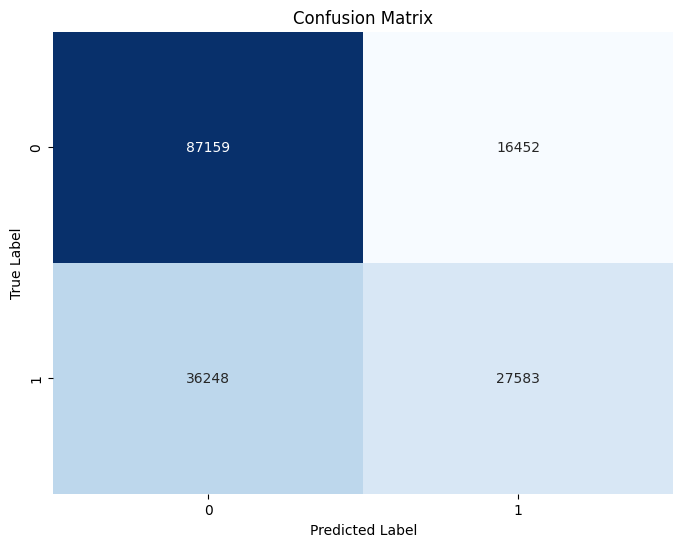

In [80]:
# Assuming y_test and y_pred_rf are defined
cm = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

 Will consider Recall because we need to reduce false positive cases

In [75]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to see the importance of each feature
feature_importance_df = pd.DataFrame({
    'Feature': X_train.drop(['ClaimID', 'Provider'], axis=1).columns,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [76]:
feature_importance_df

,Feature,Importance
0,InscClaimAmtReimbursed,0.127133
10,OPAnnualReimbursementAmt,0.126292
11,OPAnnualDeductibleAmt,0.117599
4,Diagnosis Count,0.090153
13,Age,0.088484
12,BirthYear,0.088031
14,ChronicDisease_Count,0.052566
8,IPAnnualReimbursementAmt,0.032446
2,ClaimPeriod,0.026622
17,Gender_Male,0.020024


In [85]:
# XGboost
start_time = time.time()
xgb_model = XGBClassifier(n_estimators=200, max_depth= 3, random_state=42,)
xgb_model.fit(X_train.drop(['ClaimID', 'Provider'], axis=1), y_train)
y_pred_rf = xgb_model.predict(X_test.drop(['ClaimID', 'Provider'], axis=1))
end_time = time.time()
# Time taken
execution_time = end_time - start_time
print('Execution time: ', execution_time)
print("XGboost Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Execution time:  2.5572919845581055
XGboost Classifier Report:
              precision    recall  f1-score   support

           0       0.63      0.95      0.76    103611
           1       0.58      0.11      0.19     63831

    accuracy                           0.63    167442
   macro avg       0.61      0.53      0.48    167442
weighted avg       0.61      0.63      0.54    167442

Accuracy: 0.6302540581216183
